# Case Study 1: Concrete Silo Wall with Dual Carbonation Attack

This case study examines the carbonation-induced corrosion of horizontal rebars in a concrete silo wall. The wall experiences dual carbonation, with both external and internal surfaces being affected due to differing environmental exposure conditions. 

**Key Analysis Components:**
- **Carbonation**: Progression of carbonation depth from external and internal surfaces.
- **Corrosion**: Evaluation of the probability of corrosion initiation at the rebar based on carbonation-induced depassivation.
- **Rebar Section Loss**: Estimation of rebar section loss due to corrosion.
- **Cracking Prediction**: Assess the potential for surface cracking as a result of rebar expansion due to corrosion.

**Problem Overview:**
Known parameters for this study include:
- Field-tested data such as concrete cover thickness, carbonation depth, rebar size, and concrete compressive strength.
- Environmental exposure conditions such as relative humidity (RH) and rain incidences, obtained from weather station data.

The goal of this analysis is to predict the structural deterioration of the silo wall over its service life, including carbonation progression, corrosion probability, and cracking potential.


In [1]:
# Import relevant modules from the Rational-RC package
import rational_rc.math_helper as mh  # Math helper functions
from rational_rc.carbonation import CarbonationModel  # Carbonation model

# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


## Weather data and field data

In [2]:
# Weather Data Collection (2009-2019)
# This section extracts average precipitation (wet days) and relative humidity (RH) data from the weather station.

# Wet days calculation (2009-2019 average)
wetdays = []  # List to store the wet day ratio for each year

# Loop over the years 2009 to 2019 to calculate the wet day ratio
for year in np.arange(2009, 2020, 1):
    df = pd.read_csv(f'weather/en_climate_daily_SK_4016699_{year}_P1D.csv')  # Load daily weather data
    wetdays.append(len(df[df['Total Precip (mm)'] > 2.5]) / len(df))  # Calculate wet day ratio

# Relative Humidity (RH) calculation for 2019
RHs = []  # List to store the average relative humidity (RH) for each month in 2019

# Loop over the months to calculate the average RH for each month in 2019
month_str = [f'{item:02}' for item in np.arange(1, 13)]  # Format month strings
for month in month_str:
    df = pd.read_csv(f'weather/en_climate_hourly_SK_4016699_{month}-2019_P1H.csv')  # Load hourly weather data
    RHs.append(df['Rel Hum (%)'].mean())  # Calculate monthly average relative humidity


In [3]:
# Field Carbonation Data Extraction

# Load carbonation data from Excel file
df_carbon = pd.read_excel(
    'field data/carbonation_updated_complete_cover.xlsx',  # File path
    sheet_name='Carbonation Modified',  # Sheet containing modified carbonation data
    skiprows=3,      # Skip header rows
    nrows=13,        # Number of rows to read
    usecols=('B:H')  # Columns to extract
)

# External carbonation depth (mm)
# Extract and flatten data for external carbonation depth (first 8 samples)
carbon_depth_ex = df_carbon.iloc[0:8].set_index('Sample').to_numpy().flatten()

# Internal carbonation depth (mm)
wall_thickness = 177.8      # Wall thickness in mm (7 inches)
bar_size = 12.7             # Rebar size in mm (1/2 inch)
# Calculate internal carbonation depth using the wall thickness minus the internal carbonation data
carbon_depth_in = wall_thickness - df_carbon.iloc[8:13].set_index('Sample').to_numpy().flatten()

# External concrete cover for horizontal rebar (mean and standard deviation)
cover_mean_h_ex = 44.7      # Mean external cover in mm
cover_std_h_ex = 11.2       # Standard deviation of external cover in mm

# Internal concrete cover for horizontal rebar (mean and standard deviation)
cover_mean_h_in = wall_thickness - bar_size - cover_mean_h_ex  # Calculate internal cover
cover_std_h_in = 11.2       # Standard deviation of internal cover in mm

# Project time duration
year_start = 1913           # Year the structure was built
age = 2019 - year_start     # Calculate the age of the structure


In [4]:
print(f'External carbonation depth: {carbon_depth_ex.mean():.1f} mm\n'
      f'Cover_h: {cover_mean_h_ex:.1f} mm')

print(f'\nInternal carbonation depth: {carbon_depth_in.mean():.1f} mm\n'
      f'Cover_h: {cover_mean_h_in:.1f} mm')


External carbonation depth: 31.1 mm
Cover_h: 44.7 mm

Internal carbonation depth: 115.3 mm
Cover_h: 120.4 mm


## Carbonation

In [5]:
# Define a class for storing parameters (external conditions)
class Param:
    pass

# Initialize an object to store carbonation parameters
pars_carb = Param()

# Assign raw parameters for external carbonation conditions
pars_carb.RH_real = np.array(RHs).mean()      # Mean relative humidity
pars_carb.t_c = 28                            # Number of curing days used in lab tests
pars_carb.x_c = 0.008                         # Initial guess for material propertya: accelerated test carbonation depth x_c[m]
pars_carb.ToW = np.array(wetdays).mean()      # Time of wetness (ToW): number of days with rainfall >= 2.5 mm/365
pars_carb.p_SR = 1.0                          # Probability of driving rain (1.0 for exposed vertical walls)
pars_carb.C_S_emi = 0.0                       # Additional CO2 emission (0 for no added CO2)


In [6]:
# Create Carbonation Model for External Condition (default parameters)
model_carb = CarbonationModel(pars_carb)  # Initialize carbonation model with external parameters

# Calibrate the model using the structure's age and external carbonation depth data
model_carb = model_carb.calibrate(age, carb_depth_field=carbon_depth_ex, print_out=True)

# Create Carbonation Model for Internal Condition (copy external model)
model_carb_in = model_carb.copy()

# Adjust parameters for the internal condition (no exposure to driving rain)
model_carb_in.pars.p_SR = 0.0  # Set probability of driving rain to 0 for internal surfaces

# Adjust relative humidity for the internal condition
# Assuming internal RH is an average between external RH and 50%
model_carb_in.pars.RH_real = 0.5 * (np.array(RHs).mean() + 50)

# Calibrate the internal carbonation model using the internal carbonation depth data
model_carb_in = model_carb_in.calibrate(age, carb_depth_field=carbon_depth_in, print_out=True)


carb_depth:
model: 
mean:31.10877752572361
std:14.97557351210882
field: 
mean:31.083333333333332
std:18.94821158374115
carb_depth:
model: 
mean:115.4189450986157
std:22.53544019060845
field: 
mean:115.2666666666667
std:13.363964814214215


### Horizontal rebar cover carbonation

+ **external carbonation**

Pf(g = R-S < 0) from various methods
    sample count: 0.22687218060153835
    g integral: 0.22780686245538412
    R S integral: 0.2286197867431708
    beta_factor: 0.7298142374948087
13.662503867872877 0.014888704115662305


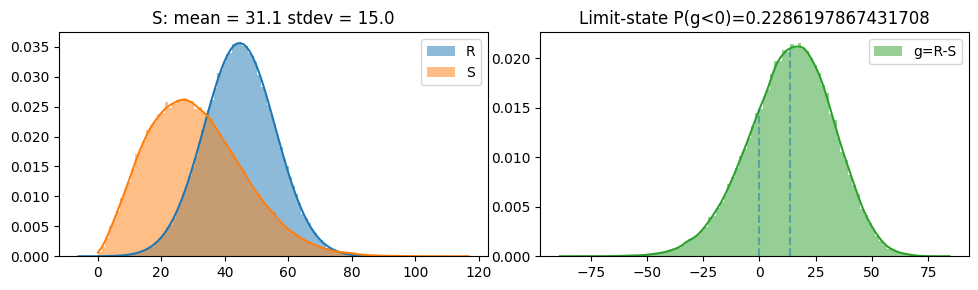

<Figure size 640x480 with 0 Axes>

In [7]:
# Carbonation Model for Horizontal Bar Cover (External Carbonation)

# Create a copy of the external carbonation model for horizontal rebar cover
model_carb_h_ex = model_carb.copy()

# Set cover parameters for horizontal rebar (external cover)
model_carb_h_ex.pars.cover_mean = cover_mean_h_ex  # Mean cover thickness (mm)
model_carb_h_ex.pars.cover_std = cover_std_h_ex  # Standard deviation of cover thickness (mm)

# Run the carbonation model for the given structure's age
model_carb_h_ex.run(age)

# Post-process the results and generate plots for visualization
model_carb_h_ex.postproc(plot=True)

# Adjust plot layout to avoid clipping of plot elements
plt.tight_layout()

# Optionally, save the plot to a file (currently disabled)
# plt.savefig('plots/carbonation_external_horizontal_2019.tiff', dpi=600)


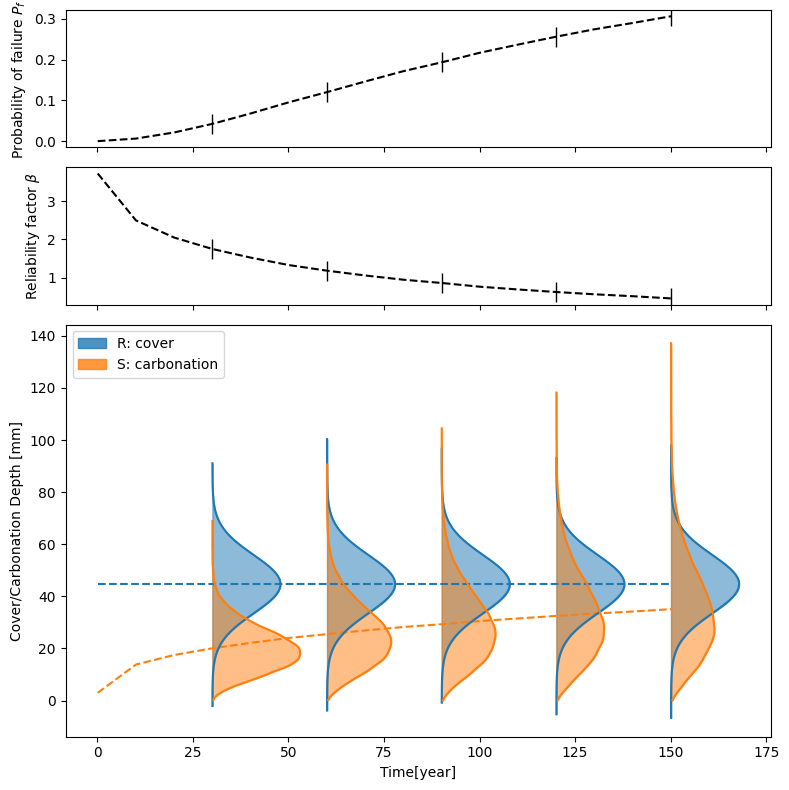

In [8]:
# Define the service life inspection points (in years)
service_life_inspect_time_list = np.arange(0.1, 150 + 1, 10)  # Inspect every 10 years, starting from 0.1 year

# Compute the probability of failure (P_f) and reliability index (β) for the external condition
# The function calculates how carbonation affects the structure over the service life
pf_lis_h_ex, beta_lis_h_ex = model_carb_h_ex.carb_with_year(
    year_lis=service_life_inspect_time_list,  # List of years for inspection
    plot=True,       # Enable plotting of the results
    amplify=500      # Amplification factor to scale the PDF for better visualization
)

# Optionally, save the plot (currently disabled)
# plt.savefig('plots/carbonation at horizontal rebar (low cover) for 150 years since Year 1913.tiff', dpi=600)


+ **internal carbonation**

Pf(g = R-S < 0) from various methods
    sample count: 0.4206899310869065
    g integral: 0.42096998817770787
    R S integral: 0.41974533021575944
    beta_factor: 0.20285812724582197
5.102467857077843 0.016077065567160088


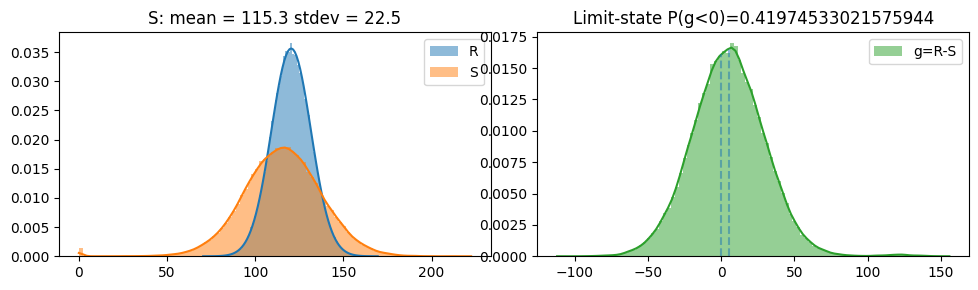

<Figure size 640x480 with 0 Axes>

In [9]:
# Carbonation Model for Horizontal Bar Cover (Internal Carbonation)

# Create a copy of the internal carbonation model for horizontal rebar cover
model_carb_h_in = model_carb_in.copy()

# Set cover parameters for horizontal rebar (internal cover)
model_carb_h_in.pars.cover_mean = cover_mean_h_in  # Mean internal cover thickness (mm)
model_carb_h_in.pars.cover_std = cover_std_h_in    # Standard deviation of internal cover thickness (mm)

# Run the carbonation model for the internal condition
model_carb_h_in.run(age)

# Post-process the results and generate plots for visualization
model_carb_h_in.postproc(plot=True)
plt.tight_layout()

# Optionally, save the plot to a file (currently disabled)
# plt.savefig('plots/carbonation_internal_horizontal_2019.tiff', dpi=600)


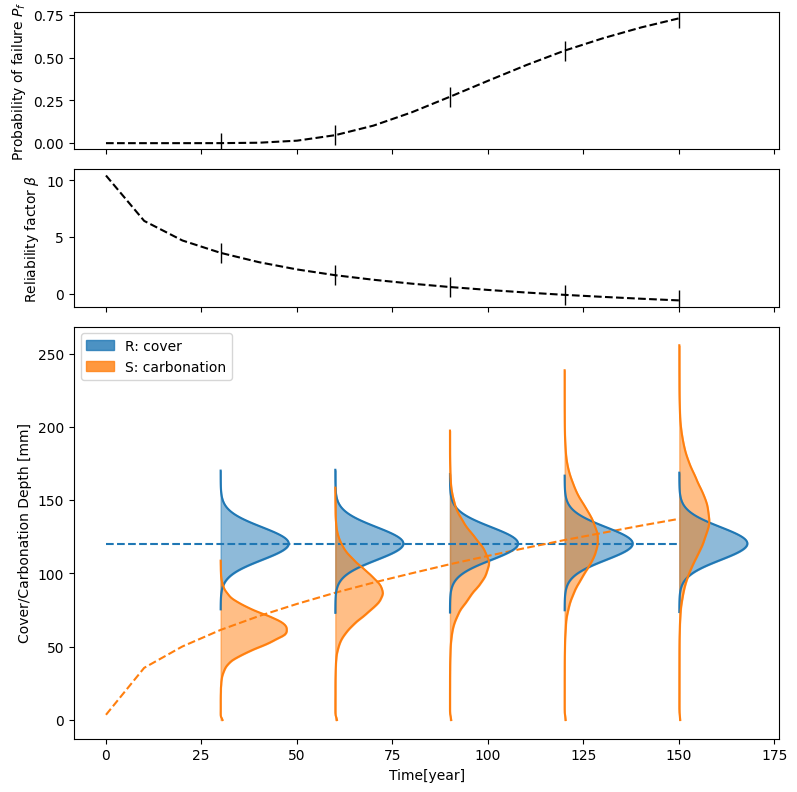

In [10]:
# Inspect service life for internal horizontal bar cover
service_life_inspect_time_list = np.arange(0.1, 150 + 1, 10)  # Inspect every 10 years, starting from 0.1 year

# Compute the probability of failure (P_f) and reliability index (β) for the internal condition
pf_lis_h_in, beta_lis_h_in = model_carb_h_in.carb_with_year(
    year_lis=service_life_inspect_time_list,  # List of years for inspection
    plot=True,       # Enable plotting of the results
    amplify=500      # Amplification factor to scale the PDF for better visualization
)

# Optionally, save the plot (currently disabled)
# plt.savefig('plots/carbonation at horizontal rebar (low cover) for 150 years since Year 1913_internal.tiff', dpi=600)


### Carbonation probability: internal, external and combined

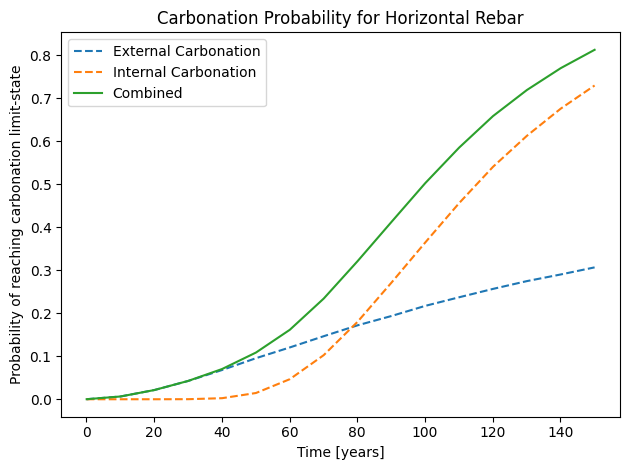

In [11]:
# Plot Carbonation Probability for Internal, External, and Combined Conditions

fig, ax = plt.subplots()

# External
ax.plot(service_life_inspect_time_list, pf_lis_h_ex, '--', label='External Carbonation')

# Internal
ax.plot(service_life_inspect_time_list, pf_lis_h_in, '--', label='Internal Carbonation')

# Calculate the combined probability of failure (union of internal and external carbonation)
# This represents the probability of at least one carbonation event (internal or external)
pf_lis_h_combine = 1 - (1 - pf_lis_h_ex) * (1 - pf_lis_h_in)
ax.plot(service_life_inspect_time_list, pf_lis_h_combine, label='Combined')

ax.set_title('Carbonation Probability for Horizontal Rebar')
ax.set_xlabel('Time [years]')
ax.set_ylabel('Probability of reaching carbonation limit-state')
ax.legend()
plt.tight_layout()

# Optionally, save the plot to a file (currently disabled)
# fig.savefig('plots/p_carbonation_horizontal_rebar.tiff', dpi=600)


## Corrosion

In [12]:
# Import Corrosion and Section Loss class from the Rational-RC Package
from rational_rc.corrosion import CorrosionModel, SectionLossModel

# CorrosionModel: Used to simulate corrosion of rebar due to carbonation or chloride ingress
# SectionLossModel: Used to model the loss of rebar cross-sectional area due to corrosion over time


In [13]:
# Initialize Corrosion Parameters for Rebar Corrosion Model

class Param: 
    pass

# Create an object to store corrosion parameters
pars_corr = Param()

# Geometry and Age
# Cover depth for horizontal rebar (converted to meters)
pars_corr.d = model_carb_h_ex.pars.cover_mean * 1e-3  # Convert mm to meters

# Age of the structure in days
pars_corr.t = 3650                 # 10 years (3650 days)

# Concrete Composition
pars_corr.cement_type = 'Type I'   # Type of cement used in the concrete mix
pars_corr.concrete_density = 2400  # Concrete density in kg/m^3 (typical value for normal weight concrete)
pars_corr.a_c = 2                  # Aggregate (fine and coarse) to cement ratio
pars_corr.w_c = 0.5                # Water-cement ratio (w/c)
pars_corr.rho_c = 3100             # Density of cement particles in kg/m^3
pars_corr.rho_a = 2600             # Density of aggregate particles (fine and coarse), range 2400-2900 kg/m^3

# Concrete Condition
pars_corr.epsilon = 0.25           # Porosity of concrete (fraction of void spaces)
pars_corr.theta_water = 0.075      # Volumetric water content (fraction)
pars_corr.T = 273.15 + 25          # Temperature in Kelvin (25°C)


In [14]:
# Initialize and Run Corrosion Model

# Initialize the corrosion model with the defined parameters
model_corr = CorrosionModel(pars_corr)

# Run the corrosion model simulation
model_corr.run()

# Extract results

# Corrosion current density (icorr) in A/m^2
icorr_A_per_m2 = model_corr.icorr
print(f"Corrosion current density, icorr [A/m^2]: {icorr_A_per_m2.mean()}")

# Corrosion rate and section loss (in mm/year)
r_corr_mm_per_year = model_corr.x_loss_rate
print(f"Section loss rate, mean [mm/year]: {r_corr_mm_per_year.mean()}")
print(f"Section loss rate, std [mm/year]: {r_corr_mm_per_year.std()}")


Corrosion current density, icorr [A/m^2]: 0.004255869509061599
Section loss rate, mean [mm/year]: 0.004928813746772031
Section loss rate, std [mm/year]: 3.7648674441932156e-05


Pf(g = R-S < 0) from various methods
    sample count: 0.00532
    g integral: 0.005469410799008344
    R S integral: 0.005016238516825065
    beta_factor: 2.7648273674445574
0.34138479493887086 0.15451019266984112


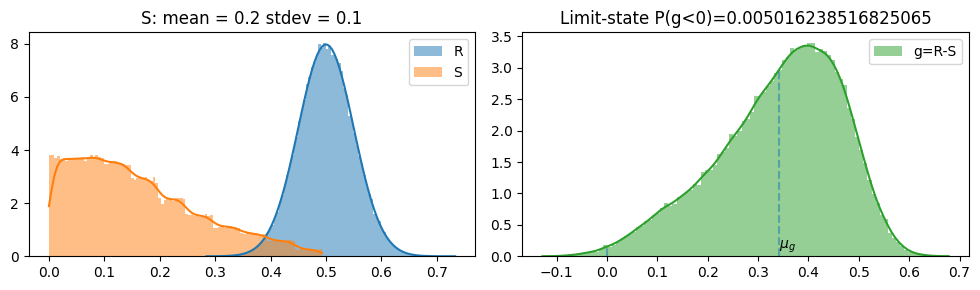

In [15]:
# Prepare parameters for section loss model
pars_sl = Param()
pars_sl.x_loss_rate = model_corr.x_loss_rate.mean()  # Mean section loss rate from corrosion model

# Probability of active corrosion over time, combining internal and external carbonation effects
pars_sl.p_active_t_curve = (service_life_inspect_time_list, pf_lis_h_combine)

# Critical section loss limits from structural analysis
pars_sl.x_loss_limit_mean = 0.5  # Mean section loss limit in mm, results of structural analysis
pars_sl.x_loss_limit_std = 0.05  # Standard deviation of section loss limit (10% of mean)

# Initialize and run the section loss model
model_sl = SectionLossModel(pars_sl)
model_sl.run(t_end=100)  # Run model up to 100 years

# Post-process and plot results
model_sl.postproc(plot=True)


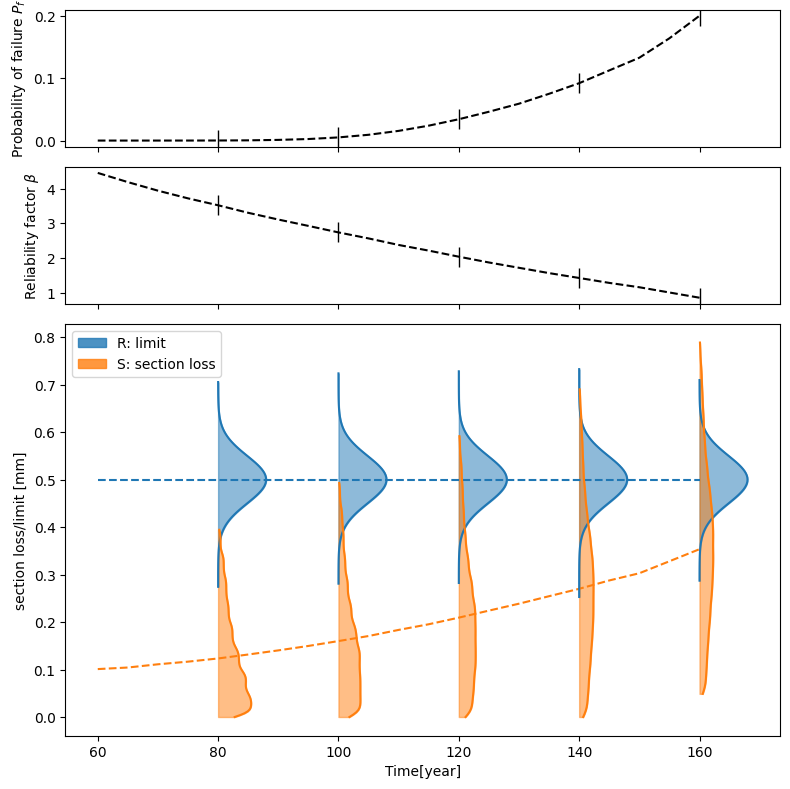

In [16]:
# Run the section loss model for a range of years (60 to 160 in steps of 5)
pf_sl, beta_sl = model_sl.section_loss_with_year(
    year_lis=np.arange(60, 160 + 5, 5),  # Year steps
    amplify=1  # Amplification factor for better visualization
)


## Cracking - Corrosion-Induced

**Assumptions:**
- No other external stresses are considered.

**Steps:**
1. **Time to Surface Crack**: Calculate the time required for surface cracking in the external concrete cover due to rebar expansion (horizontal rebar).
2. **Combine with Corrosion Probability**: Integrate the probability of corrosion onset to estimate the likelihood of surface cracking.


In [17]:
# Import the Cracking Model and helper functions
from rational_rc.cracking import CrackingModel
from rational_rc.math_helper import normal_custom

# Display external carbonation depth and cover
print(f'External carbonation depth: {carbon_depth_ex.mean():.1f} mm\n'
      f'External cover: {cover_mean_h_ex:.1f} mm')

# Display internal carbonation depth and cover
print(f'\nInternal carbonation depth: {carbon_depth_in.mean():.1f} mm\n'
      f'Internal cover: {wall_thickness - cover_mean_h_in:.1f} mm')


External carbonation depth: 31.1 mm
External cover: 44.7 mm

Internal carbonation depth: 115.3 mm
Internal cover: 57.4 mm


### horizontal rebar - external cover

In [18]:
# Cracking Model for Horizontal External Cover (Low Cover)

class Param: pass
pars_cr = Param()

# Rebar and concrete properties
r0_bar_mean = 12.7e-3  # Rebar radius in meters (1/2 inch)
f_c = 20               # Concrete compressive strength in MPa
rho_c = 2400           # Concrete density in kg/m³

# Concrete tensile strength and modulus of elasticity (from design code CSA A23.3-04)
f_t_mean = f_c * 0.1                                       # Concrete tensile strength in MPa
E_0_mean = (3300 * f_c**0.5 + 6900) * (rho_c / 2300)**1.5  # Modulus of elasticity
                                                           # ACI Committee 363 f 21<fc<83 MPa Design code CSA A23.3-04


# Horizontal rebar cover distribution (external)
pars_cr.cover = normal_custom(cover_mean_h_ex * 1e-3, cover_std_h_ex * 1e-3, non_negative=True)  # Rebar cover in meters

# Assumed distributions for material properties
pars_cr.f_t = normal_custom(f_t_mean, 0.2 * f_t_mean, non_negative=True)           # Concrete tensile strength
pars_cr.E_0 = normal_custom(E_0_mean, 0.2 * E_0_mean, non_negative=True)           # Modulus of elasticity
pars_cr.r0_bar = normal_custom(r0_bar_mean, 0.1 * r0_bar_mean, non_negative=True)  # Rebar radius
pars_cr.w_c = normal_custom(0.8, 0.1 * 0.8, non_negative=True)                     # Water-cement ratio
pars_cr.r_v = mh.beta_custom(2.96, 2.96 * 0.05, 3.3, 2.6)  # Rust volumetric expansion rate, mean 2.96 lower 2.6  upper: 3.3

# Section loss rate (mean and std) converted to m/year
x_loss_rate_m_year_mean = model_corr.x_loss_rate.mean() * 1e-3  
x_loss_rate_m_year_std = model_corr.x_loss_rate.std() * 1e-3 

# Initialize section loss distribution (to be updated later)
pars_cr.x_loss = normal_custom(x_loss_rate_m_year_mean * 0.1, 1e-16, non_negative=True)

# Initialize cracking model
model_crack = CrackingModel(pars_cr)


In [19]:
# surface crack vs time [NOTE: 5 min runtime]
model_crack_lis = []

from tqdm import tqdm # add progress bar
_years = np.arange(0.5,10,0.2)
# Iterate over time steps, adjusting section loss for each year
for _year in tqdm(_years):
    model_crack.pars.x_loss = normal_custom(x_loss_rate_m_year_mean * _year, 
                                            x_loss_rate_m_year_std * _year, 
                                            non_negative=True)
    
    # Run the cracking model in stochastic mode
    model_crack.run(stochastic=True)
    
    # Post-process results and store the model copy in the list
    model_crack.postproc()
    model_crack_lis.append(model_crack.copy())
    


100%|██████████| 48/48 [03:51<00:00,  4.83s/it]


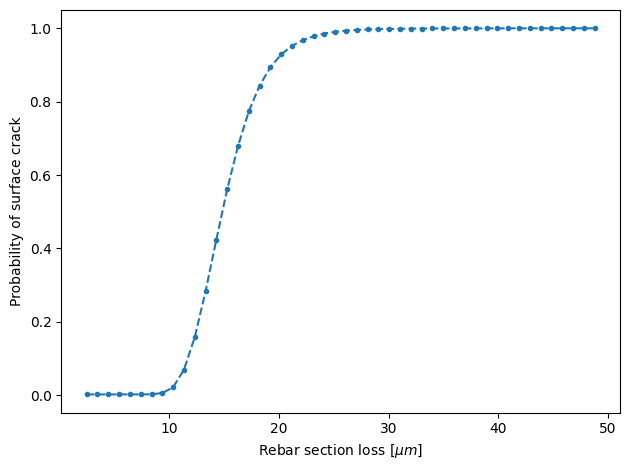

In [20]:
# Plot surface crack probability vs rebar section loss
fig,ax=plt.subplots()
x_loss_array = _years * x_loss_rate_m_year_mean
p_surface_crack_array = np.array([m.crack_visible_rate_count for m in model_crack_lis])
ax.plot(x_loss_array*1e6,p_surface_crack_array, '--.')
ax.set_xlabel('Rebar section loss $[\mu m]$')
ax.set_ylabel('Probability of surface crack')
plt.tight_layout()

# Optionally save the plot and data to disk (currently disabled)
# plt.savefig('plots/Corrosion-induced surface crack for horizontal rebar (low cover).pdf',dpi=600)
# pd.DataFrame({'section loss[m]':x_loss_array, 'probability of surface crack':p_surface_crack_array}).to_csv("tables/section loss and surface cracking.csv", index=None)

### Propagated probability of surface crack at time t depending on the onset of carbonation-induced corrosion

In [21]:
def p_crack_t_fun(t, r_corr_mean, p_carbonation_t_curve, p_surface_crack_x_loss_curve):
    """
    Calculate the propagated probability of surface cracking over time, 
    considering carbonation-induced corrosion onset.

    Args:
    t : array-like
        Time steps for inspection.
    r_corr_mean : float
        Mean corrosion rate (section loss).
    p_carbonation_t_curve : tuple
        Interpolated carbonation curve (service_life_inspect_time_list, pf_lis_h).
    p_surface_crack_x_loss_curve : tuple
        Surface crack probability curve based on section loss (x_loss_array, p_surface_crack_array).

    Returns:
    np.array : Propagated probability of surface cracking over time.
    """

    p_crack_t = []  # Store the propagated probabilities over time

    # Unpack the carbonation probability curve and surface crack probability curve
    service_life_inspect_time_list, pf_lis_h = p_carbonation_t_curve
    x_loss_array, p_surface_crack_array = p_surface_crack_x_loss_curve
    
    # Iterate through each time step in t
    for ti in t:
        # Inspect for the current time step ti
        t_lis = t[0: np.where(t == ti)[0][0] + 1]
        age_lis = ti - t
        age_lis = age_lis[age_lis >= 0]  # Filter for positive age durations
        x_loss_lis = age_lis * r_corr_mean  # Calculate section loss over time

        # Interpolate surface crack probability based on section loss
        p_crack_xloss_lis = np.interp(x_loss_lis, x_loss_array, p_surface_crack_array)

        # Interpolate carbonation probability onset curve
        pf_lis = np.interp(t_lis, service_life_inspect_time_list, pf_lis_h)

        # Calculate incremental probability of corrosion onset over time
        p_corr_onset_lis = np.diff(pf_lis, prepend=0)

        # Calculate the propagated probability of at least one crack occurring
        p_crack_t.append(1 - np.prod(1 - p_crack_xloss_lis * p_corr_onset_lis))

    return np.array(p_crack_t)


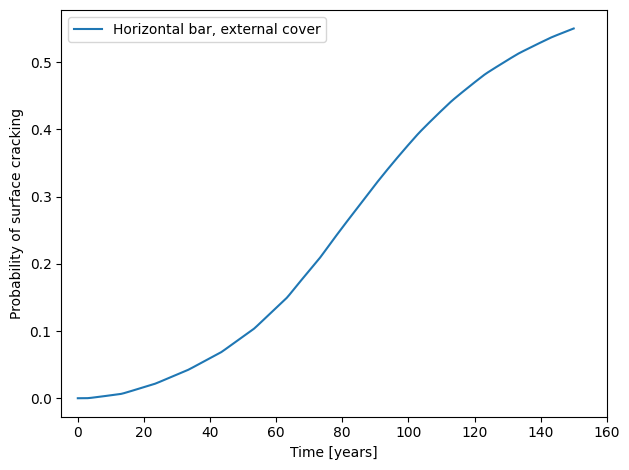

In [22]:
# Define time steps for the analysis (0 to 150 years, in increments of 0.1 year)
t = np.arange(0, 150.1, 0.1)

# Calculate propagated probability of surface cracking for horizontal bar external surface
p_crack_t = p_crack_t_fun(
    t,
    x_loss_rate_m_year_mean,
    p_carbonation_t_curve=(service_life_inspect_time_list, pf_lis_h_combine), 
    p_surface_crack_x_loss_curve=(x_loss_array, p_surface_crack_array)
)

# Plot the probability of surface cracking over time
fig, ax = plt.subplots()
ax.plot(t, p_crack_t, '-', label='Horizontal bar, external cover')

ax.set_xlim(-5, 160)
ax.set_xlabel('Time [years]')
ax.set_ylabel('Probability of surface cracking')
plt.tight_layout()
plt.legend()

# Optionally save the plot (currently disabled)
# fig.savefig('plots/p_surface_crack_vs_year.tiff', dpi=600)

plt.show()
